This notebook shows how to train a random forest classifier that classifies any given chemical composition into one of three kinds of material types: quasicrystals (QCs), approximant crystals (ACs), and others (OTHERS) including ordinary periodic crystals, and to perform a virtual screening to predict a set of chemical compositions to form quasicrystalline phases. The dataset includes chemical compositions of 80 QCs, 78 ACs, and 10,000 ordinary crystals that have been discovered to date.

You can assess [our paper](https://onlinelibrary.wiley.com/doi/10.1002/adma.202102507) to know the details of the data analysis workflow. The pre-trained model can be downloaded from [here](https://github.com/yoshida-lab/XenonPy/releases/download/v0.6.5/best_QC_AC_classification_model.pkl.z).

XenonPy with version v0.6.5 or higher is needed to execute the following codes. Please follow the [official installation guide](https://xenonpy.readthedocs.io/en/latest/installation.html#using-conda-and-pip) to prepare your local environment.

In [1]:
%run tools.ipynb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from pathlib import Path
from matplotlib import pyplot as plt

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# version should greater than 0.6.5

import xenonpy as xe
xe.__version__

'0.6.5'

### Model training

The model is trained using the optimized hyperparameters in the previous paper; the list of chemical compositions for `QC` and `AC` was collected from the literature, and the list of 10,000 compositions for `OTHERS` was randomly selected from the [Materials Project database](https://materialsproject.org/). 

#### load training data

In [3]:
training_data = pd.read_csv(
    'training_data.csv',
    index_col=0,
    converters={'composition': eval, 'elements': eval},
)

training_data
training_data.label.unique()

,composition,elements,label,for_test
mp-1077980,"{'Sr': 1.0, 'Ag': 4.0, 'Sb': 2.0}","(Ag, Sb, Sr)",OTHERS,False
mp-30079,"{'Li': 1.0, 'Mg': 2.0, 'Ge': 1.0}","(Ge, Li, Mg)",OTHERS,False
mvc-2967,"{'Ba': 2.0, 'Tl': 1.0, 'Fe': 2.0, 'O': 7.0}","(Ba, Fe, O, Tl)",OTHERS,False
mp-1202279,"{'K': 18.0, 'Ho': 18.0, 'F': 72.0}","(F, Ho, K)",OTHERS,False
mp-34421,"{'Bi': 3.0, 'Cd': 1.0, 'O': 7.0}","(Bi, Cd, O)",OTHERS,False
...,...,...,...,...
mp-5960,"{'O': 12.0, 'Ca': 6.0, 'U': 2.0}","(Ca, O, U)",OTHERS,True
mp-1198997,"{'C': 16.0, 'S': 8.0, 'N': 8.0, 'O': 8.0, 'F':...","(C, F, N, O, S)",OTHERS,True
mp-1219422,"{'Sc': 28.0, 'As': 12.0}","(As, Sc)",OTHERS,True
mp-757593,"{'Li': 4.0, 'Co': 5.0, 'Sb': 1.0, 'O': 12.0}","(Co, Li, O, Sb)",OTHERS,True


array(['OTHERS', 'QC', 'AC'], dtype=object)

As described above, the dataset consists of three class labels, `QC`, `AC`, and `OTHERS`.

#### Calculate compositional descriptors

We use `xenonpy.descriptor.Compositions` to calculate the 232-dimensional compositional descriptors. As described in [our paper](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202102507), we use `weighted average`, `weighted variance`, `max-pooling`, and `min-pooling` of the 58 element features (4 $\times$ 58 = 232-dimension).

In [4]:
from xenonpy.descriptor import Compositions

# use specific featurizers
featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']

compositions = Compositions(featurizers=featurizers, n_jobs=20)
compositions.fit_transform?

Signature: compositions.fit_transform(X, y=None, **fit_params)
Docstring:
Fit to data, then transform it.

Fits transformer to `X` and `y` with optional parameters `fit_params`
and returns a transformed version of `X`.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Input samples.

y :  array-like of shape (n_samples,) or (n_samples, n_outputs),                 default=None
    Target values (None for unsupervised transformations).

**fit_params : dict
    Additional fit parameters.

Returns
-------
X_new : ndarray array of shape (n_samples, n_features_new)
    Transformed array.
File:      ~/mambaforge/envs/xepy38/lib/python3.8/site-packages/sklearn/base.py
Type:      method


To use the following calculator, users need to feed an iterable object containing the compositional information of compounds to `cal.transform` or `cal.fit_transform` method. The data type in the iterable object can be `pymatgen.core.Compositon`, or a python `dict`, for example, {‘H’: 2, ‘O’: 1}.

In [5]:
%%time

desc = compositions.fit_transform(training_data.composition)

desc

CPU times: user 3.05 s, sys: 567 ms, total: 3.61 s
Wall time: 5.91 s


,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-1077980,46.857143,158.428571,238.714286,15.957143,108.944686,2201.857143,79.497211,800.285714,150.428571,139.571429,...,1.0,5.0,0.205,24.00000,206.0,247.0,243.0,314.8,2600.000000,6.600
mp-30079,14.750000,153.000000,233.500000,13.675000,32.045000,1736.787500,49.384485,758.250000,132.500000,133.000000,...,1.0,2.0,0.322,60.00000,173.0,212.0,243.0,245.1,4602.000000,5.840
mvc-2967,25.083333,157.534162,206.416667,17.283333,58.559750,1018.944167,77.911857,1066.825000,110.083333,100.750000,...,2.0,2.0,0.128,0.02658,152.0,150.0,182.0,291.2,317.500000,0.802
mp-1202279,20.333333,158.349076,193.166667,22.066667,46.670374,725.840000,38.382626,1038.466667,103.833333,103.000000,...,1.0,2.0,0.164,0.02770,147.0,146.0,171.0,336.4,2000.000000,0.557
mp-34421,32.090909,153.400904,198.636364,15.909091,77.395291,665.302727,60.703844,187.354545,95.454545,93.636364,...,2.0,2.0,0.124,0.02658,152.0,150.0,182.0,284.8,317.500000,0.802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-5960,20.000000,160.620852,211.900000,18.620000,45.425691,983.014000,60.763625,928.149258,112.000000,106.100000,...,2.0,2.0,0.115,0.02658,152.0,150.0,182.0,339.5,317.500000,0.802
mp-1198997,8.666667,113.537506,184.500000,12.416667,17.514401,1861.737333,42.328311,48.066667,74.166667,75.166667,...,2.0,2.0,0.711,0.02583,147.0,146.0,171.0,336.4,317.500000,0.557
mp-1219422,24.600000,155.100000,253.400000,14.430000,53.945614,2435.600000,46.500000,1177.000000,154.700000,139.900000,...,2.0,4.0,0.328,16.00000,185.0,188.0,236.0,329.5,3638.678266,4.310
mp-757593,13.363636,143.564411,194.909091,12.377273,28.916999,1053.540000,86.330568,393.154545,96.954545,90.136364,...,1.0,2.0,0.205,0.02658,152.0,150.0,182.0,245.1,317.500000,0.802


#### Train the model

In [our paper](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202102507), we performed a grid searching to find the best hyperparameters of the random forest classifier. For simplicity as a demonstration, we use the already optimized hyperparameters.


```python
param_grid = dict(
    random_state=[0],
    max_depth=[5, 10, 15, 20, 25],
    n_estimators=[50, 100, 200, 300],
    max_features=['sqrt', 'log2', None],
    bootstrap=[True, False],
    criterion=["gini", "entropy"]
)
```

Best parameters:
```python
hyperparams = dict(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)
```

In order to evaluate the model performance, we split the entire dataset into `train` and `test` datasets. We assigned the flag `for_test` to the data to indicate which samples were used for testing in the model construction process in the previous work. While you can use this flag to reproduce our work, here we would like to show you the standard procedure on how to learn the model.

There are lots of choices to do this work, here we use the `xenonpy.datatools.Splitter` class.

In [6]:
from xenonpy.datatools import Splitter

Splitter?

Init signature:
Splitter(
    size: int,
    *,
    test_size: Union[float, int] = 0.2,
    k_fold: Union[int, Iterable, NoneType] = None,
    random_state: Union[int, NoneType] = None,
    shuffle: bool = True,
)
Docstring:      Data splitter for train and test
Init docstring:
Parameters
----------
size
    Total sample size.
    All data must have same length of their first dim,
test_size
    If float, should be between ``0.0`` and ``1.0`` and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. Can be ``0`` if cv is ``None``.
    In this case, :meth:`~Splitter.cv` will yield a tuple only contains ``training`` and ``validation``
    on each step. By default, the value is set to 0.2.
k_fold
    Number of k-folds.
    If ``int``, Must be at least 2.
    If ``Iterable``, it should provide label for each element which will be used for group cv.
    In this case, the input of :meth:`~Splitter.cv` must be a :c

In [7]:
splitter = Splitter(size=desc.shape[0], random_state=0, test_size=0.2)
splitter

Splitter(random_state=0, size=10158)

In [8]:
x_train, x_test, y_train, y_test = splitter.split(desc, training_data.label)

x_train.shape
y_train.shape
x_test.shape
y_test.shape

(8126, 232)

(8126,)

(2032, 232)

(2032,)

Use [scikit-learn random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier) to train the model

In [9]:
from sklearn.ensemble import RandomForestClassifier

# prepare the random forest class
rfc = RandomForestClassifier(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)

rfc

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

In [10]:
# train the model with training data
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

Predict the class label of training and test data

In [11]:
y_pred, y_true = rfc.predict(x_test), y_test
y_pred_fit, y_true_fit = rfc.predict(x_train), y_train

#### confusion matrix

The confusion matrix is a common measure used to summarize the predicted results of a classification task. For more information, see [here](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).

In [12]:
# import a library for evaluating the model performance based on confusion matrix
from sklearn.metrics import confusion_matrix

labels = ['OTHERS', 'QC', 'AC']
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_fit = confusion_matrix(y_true_fit, y_pred_fit, labels=labels)

print('Testing CM:')
cm

print('\nTraining CM:')
cm_fit

Testing CM:


array([[1993,    1,    1],
       [   3,    8,    3],
       [   5,    5,   13]])


Training CM:


array([[8005,    0,    0],
       [   0,   66,    0],
       [   0,    0,   55]])

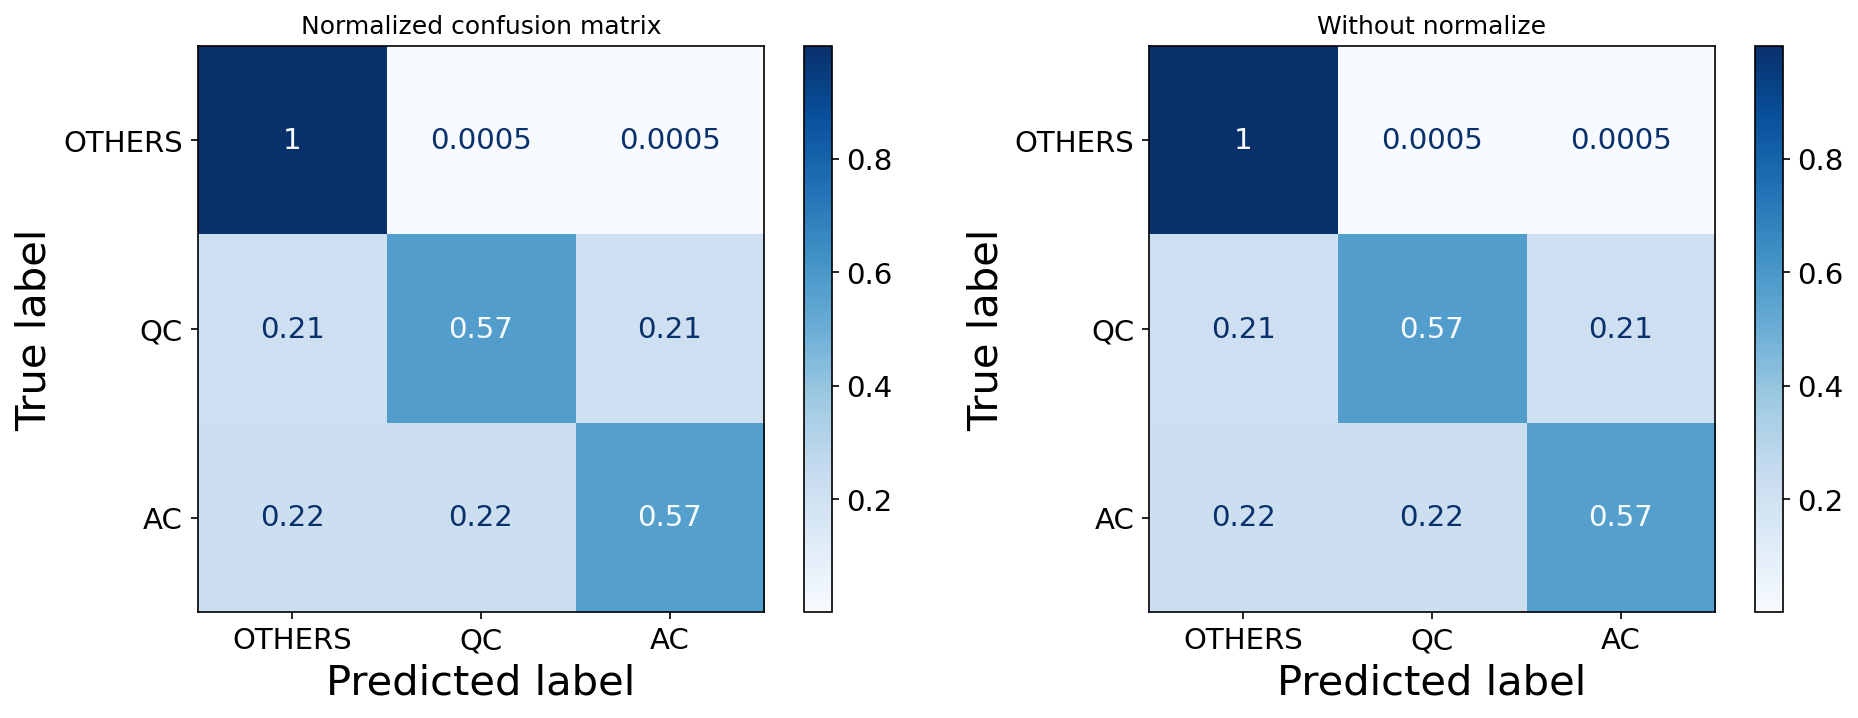

In [13]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
cm = cm / cm.sum(axis=1, keepdims=True)
cmd = ConfusionMatrixDisplay(cm, labels)
_ = cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax1)
_ = ax1.set_title("Normalized confusion matrix")

cmd = ConfusionMatrixDisplay(cm, labels)
_ = cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax2)
_ = ax2.set_title("Without normalize")

Finally, save the model for further use.

In [14]:
import joblib

Path('pre_trained_model/').mkdir(exist_ok=True, parents=True)
joblib.dump(rfc, 'pre_trained_model/classification_model_with_taining_data.pkl.z')

['pre_trained_model/classification_model_with_taining_data.pkl.z']

### Virtual screening

The trained model can be used to predict the structure type (QC, AC, and OTHERS) of any given chemical composition. Here we focus only on ternary systems. In the following, we describe the procedure of virtual screening and its visualization in a ternary phase diagram.

For the sake of demonstration, we will select a system as a prediction target in which quasicrystals are already known to be present.

In [15]:
test_data = training_data.loc[x_test.index].assign(prediction=y_pred).drop(columns=['composition', 'for_test'])

test_data[(test_data.label == 'QC') & (test_data.prediction == 'QC')]

,elements,label,prediction
Cd 65 Mg 20 Gd 15,"(Cd, Gd, Mg)",QC,QC
Zn 75 Sc 15 Ag 10,"(Ag, Sc, Zn)",QC,QC
Zn 58 Mg 40 Lu 2,"(Lu, Mg, Zn)",QC,QC
Zn 75 Sc 15 Pd 10,"(Pd, Sc, Zn)",QC,QC
Al 65 Cu 20 Os 15,"(Al, Cu, Os)",QC,QC
Zn 76 Mg 17 Hf 7,"(Hf, Mg, Zn)",QC,QC
Al 70 Pd 20 Re 10,"(Al, Pd, Re)",QC,QC
Cd 65 Mg 20 Y 15,"(Cd, Mg, Y)",QC,QC


Let's draw a predicted phase diagram of the Al-Cu-Os system.

#### Virtual composition

First, a set of virtual chemical compositions covering the entire compositional space of $\mathrm{Al}_a \mathrm{Cu}_b \mathrm{Os}_c$ is generated ($a$, $b$, $c$ denote the composition ratio). The function `make_virtual_compounds` is provided to simplify this step.


In [16]:
make_virtual_compounds?

Signature:
make_virtual_compounds(
    *elements,
    interval=0.5,
    pen_size=10,
    reorder_elements=True,
    max_proportion=100,
    **element_ratio,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_577836/3766468394.py
Type:      function


In [17]:
target = ('Al', 'Cu', 'Os')

v_comps = make_virtual_compounds(*target, reorder_elements=False, interval=0.25, max_proportion=100)
v_comps

,composition,elements
0,"{'Al': 0.25, 'Cu': 99.75, 'Os': 0.0}","(Al, Cu, Os)"
1,"{'Al': 0.5, 'Cu': 99.5, 'Os': 0.0}","(Al, Cu, Os)"
2,"{'Al': 0.75, 'Cu': 99.25, 'Os': 0.0}","(Al, Cu, Os)"
3,"{'Al': 1.0, 'Cu': 99.0, 'Os': 0.0}","(Al, Cu, Os)"
4,"{'Al': 1.25, 'Cu': 98.75, 'Os': 0.0}","(Al, Cu, Os)"
...,...,...
80593,"{'Al': 0.0, 'Cu': 0.5, 'Os': 99.5}","(Al, Cu, Os)"
80594,"{'Al': 0.25, 'Cu': 0.25, 'Os': 99.5}","(Al, Cu, Os)"
80595,"{'Al': 0.5, 'Cu': 0.0, 'Os': 99.5}","(Al, Cu, Os)"
80596,"{'Al': 0.0, 'Cu': 0.25, 'Os': 99.75}","(Al, Cu, Os)"


#### Calculate the descriptors of candidate compositions and predict their class labels

In [18]:
%%time

v_desc = compositions.fit_transform(v_comps)
v_desc.shape

CPU times: user 17.3 s, sys: 849 ms, total: 18.2 s
Wall time: 18.1 s


(80598, 232)

In [19]:
pred_proba = pd.DataFrame(rfc.predict_proba(v_desc), columns=rfc.classes_)
pred_labels = pred_proba.assign(pred_label=rfc.predict(v_desc))
pred_results = pd.concat([v_comps, pred_labels], axis=1)
pred_results

,composition,elements,AC,OTHERS,QC,pred_label
0,"{'Al': 0.25, 'Cu': 99.75, 'Os': 0.0}","(Al, Cu, Os)",0.060,0.870,0.070,OTHERS
1,"{'Al': 0.5, 'Cu': 99.5, 'Os': 0.0}","(Al, Cu, Os)",0.060,0.865,0.075,OTHERS
2,"{'Al': 0.75, 'Cu': 99.25, 'Os': 0.0}","(Al, Cu, Os)",0.060,0.865,0.075,OTHERS
3,"{'Al': 1.0, 'Cu': 99.0, 'Os': 0.0}","(Al, Cu, Os)",0.065,0.860,0.075,OTHERS
4,"{'Al': 1.25, 'Cu': 98.75, 'Os': 0.0}","(Al, Cu, Os)",0.070,0.855,0.075,OTHERS
...,...,...,...,...,...,...
80593,"{'Al': 0.0, 'Cu': 0.5, 'Os': 99.5}","(Al, Cu, Os)",0.015,0.935,0.050,OTHERS
80594,"{'Al': 0.25, 'Cu': 0.25, 'Os': 99.5}","(Al, Cu, Os)",0.015,0.935,0.050,OTHERS
80595,"{'Al': 0.5, 'Cu': 0.0, 'Os': 99.5}","(Al, Cu, Os)",0.020,0.935,0.045,OTHERS
80596,"{'Al': 0.0, 'Cu': 0.25, 'Os': 99.75}","(Al, Cu, Os)",0.015,0.935,0.050,OTHERS


#### Draw a phase diagram

Here, we generate a phase diagram to visualize the predicted structure types (`QC`, `AC`, and `OTHERS`) in the ternary system.

In [20]:
labels = ['OTHERS', 'QC', 'AC']
k_folds = 10
cmap = 'YlGnBu'
n = 1
criteria = 'mae'
epa_color = 'orangered'
pe_color = 'aqua'

norm = matplotlib.colors.BoundaryNorm(np.linspace(-1.5, 1.5, 4), 3)
fmt = matplotlib.ticker.FuncFormatter(lambda x, _: ['OTHERS', 'AC', 'QC'][norm(x)])

def trans(s):
    if s == 'QC': return 1.5
    if s == 'AC': return 0
    if s == 'OTHERS': return -1.5

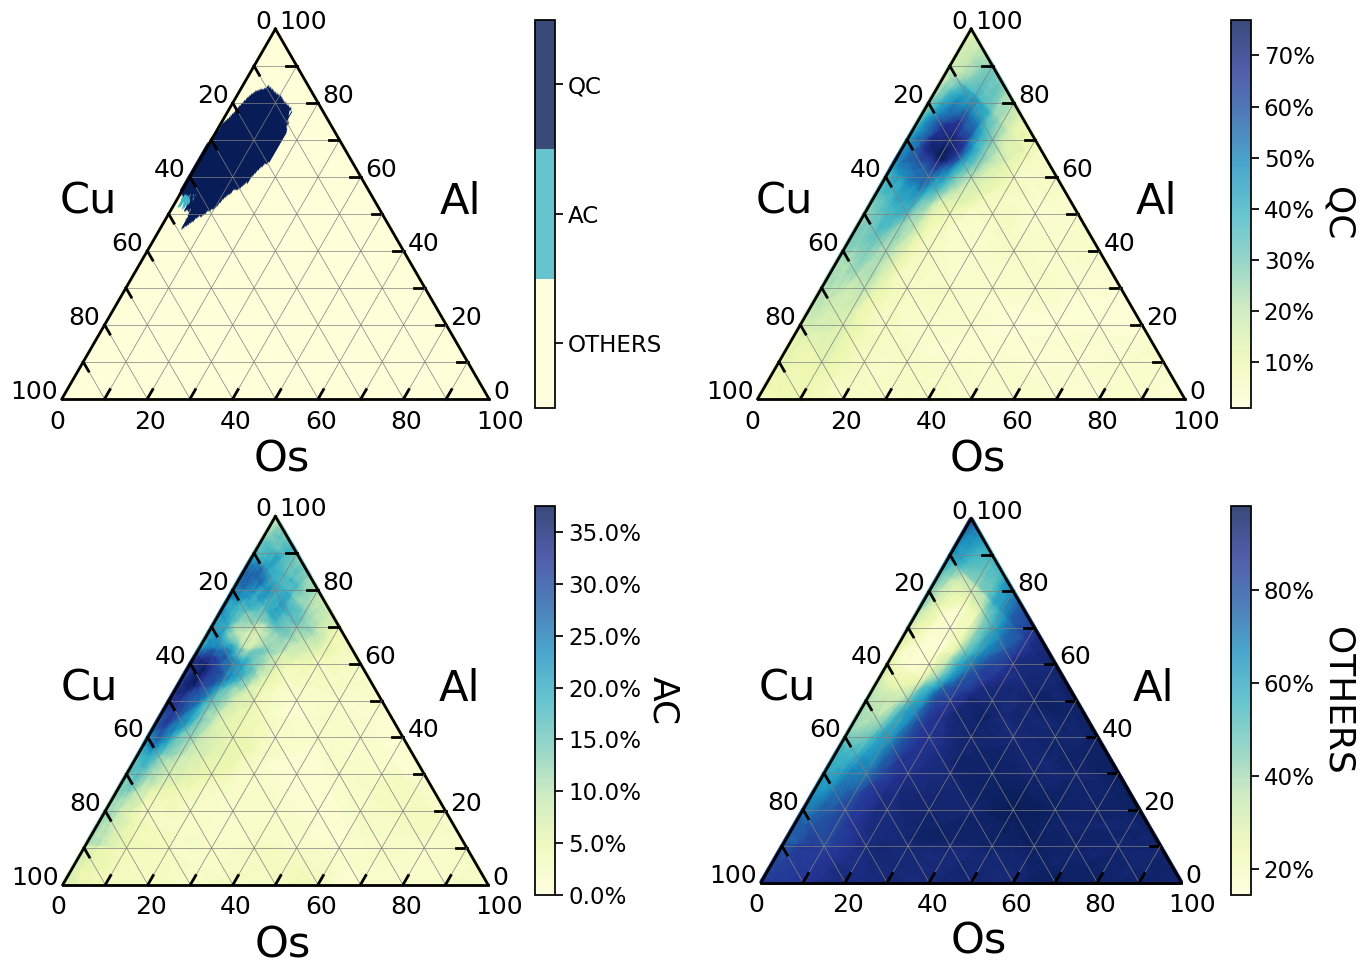

In [21]:
# set overall style
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.labelsize": "large"})

a, b, c = target
tmp = pd.DataFrame([{k: v for k, v in s.items()} for s in pred_results.composition], index=pred_results.index)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# all class
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.pred_label.apply(trans).values,
    a, b, c,
    cbar_kw=dict(
     format=fmt,
     ticks=np.arange(-1, 2)
    ),
    cmap=plt.get_cmap(cmap, 3),
    norm=norm,
    half_size=False,
    reduce_ticks=True,
    ax=ax1
)


# QC
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.QC,
    a, b, c,
    cbarlabel='QC',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax2
)

# AC
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.AC,
    a, b, c,
    cbarlabel='AC',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax3
)

# OTHERS
plot_tri(
    tmp[a].values * n,
    tmp[b].values * n,
    tmp[c].values * n,
    pred_results.OTHERS,
    a, b, c,
    cbarlabel='OTHERS',
    cmap=cmap,
    percentage=True,
    half_size=False,
    reduce_ticks=True,
    ax=ax4
)

# save figure
Path('phase_diagram/').mkdir(exist_ok=True, parents=True)
plt.savefig(f"phase_diagram/{'_'.join(target)}.png", bbox_inches='tight', pad_inches=0, dpi=300)


### Retrain a model with all data

Finally, we retrain the model using the optimized hyperparameters with all data and save it.

In [22]:
# prepare the random forest class
rfc = RandomForestClassifier(
    random_state=0,
    max_depth=25,
    n_estimators=200,
    max_features='log2',
    bootstrap=False,
    criterion="entropy",
)

rfc.fit(desc, training_data.label)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, random_state=0)

In [23]:
joblib.dump(rfc, 'pre_trained_model/classification_model_with_all_data_training.pkl.z')

['pre_trained_model/classification_model_with_all_data_training.pkl.z']